# Lab 2

*Authors: Pablo Montes, Oscar Reula, Joaquin Pelle*

##### [Click here to download this notebook](/weave/lab02/lab2.ipynb)

### Important 1: ###

This notebook is designed to be run in Julia.

### Important 2: ###

Rename the file as: 

`lastname_firstname_lab_2.ipynb`

**All generated code and the presentation must be included in this notebook.**

**The objectives of the first assignments are varied:**

1. Build some simple integrators and apply them to problems in 1 and 2 dimensions.
2. Study convergence and determine the method's Q factor.
3. Study the convergence region of the methods.
4. Check the approximation errors both qualitatively and quantitatively.
5. Get familiar with ODE integrator libraries.
6. Get familiar with handling and analyzing solutions in moderately complex cases.
7. Study the stiff case and IMEX methods.


**1)** The differential equation

$$
\frac{dy}{dt} = \lambda y
$$

has as its solution the function  
$$ y(t) = Ce^{\lambda t}, $$
where $C$ is a constant that depends on the initial condition.

We will solve it numerically using the Euler method,  
$$y(t+\Delta t) \approx y(t) + \Delta t \dfrac{dy}{dt}(t) = y(t) + \Delta t \lambda y(t)$$  
taking $\lambda = 2$ and initial condition $y(0) = 1$ over the time interval $[0,2]$.



**Implementation of the method:**

A simple way to implement the Euler method would be the following:


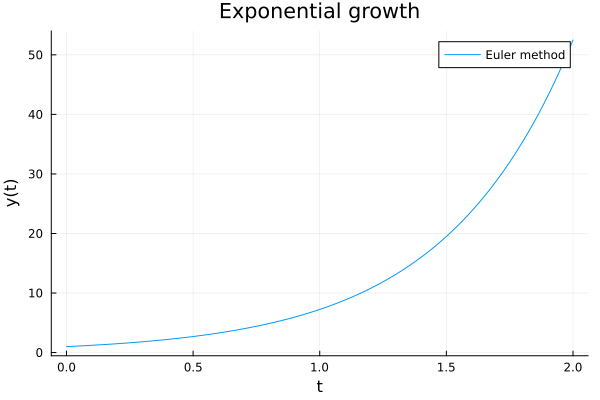

In [6]:
using Plots
# Initial data
λ = 2
y0 = 1
# Number of time steps and dt
Tfin = 2.0
N = 201
dt = Tfin/(N-1)

# Vectors to store the solution
times = zeros(N)
y = zeros(N)
y[1] = y0
# Time evolution using the Euler method
for i in 2:N
    times[i] = dt*(i-1)      # Update the value of t
    y[i] = y[i-1] + dt*λ*y[i-1]  # Perform one Euler step
end
plot(times, y, label="Euler method", xlabel="t", ylabel="y(t)", title="Exponential growth", legend=:topright)

What we will do is split this procedure into a few small functions, so that in the future, if we want to change the numerical method or solve a different differential equation, we can do so directly. 


Our implementation of Euler's method is as follows:

In [7]:
# Functions to numerically solve equations of the form dy/dt = f(y, par, t)

function EulerStep(y, f, par, t, dt)
    """Euler method"""
    return y + dt * f(y, par, t)          # Euler method step
end

function myODEproblem(f, y0, interval, par)
    """Return f, y0, the time interval, and the function parameters as a tuple"""
    return (f, y0, interval, par)
end

function myODEsolver(Problem, Method; dt::Float64 = 0.01)
    # Solve the problem 'Problem' using the method 'Method' with time step dt
    f, y0, interval, par = Problem         # Specific data for the problem we're solving
    tini, tfin = interval                  # Initial and final times
    N = 1 + convert(Int64, (tfin - tini) / dt)  # Number of time steps
    y = Array{typeof(y0[1])}(undef, N, length(y0))  # Array to store y
    t = zeros(N)                           # Array to store t
    y[1,:] .= y0                           # Initial condition
    t[1] = tini
    for i in 2:N
        t[i] = tini + (i - 1) * dt
        y[i,:] .= Method(y[i-1,:], f, par, t[i-1], dt)   # Time step
    end
    return (t, y)
end


myODEsolver (generic function with 1 method)

In [18]:
# 1) Problem data:
# Define the right-hand side of the ODE
ExponentialGrowth(y, λ, t) = λ*(y)
# Initial data
λ = -1.0 
y0 = 1.0 + 0.0im
# Time interval
T = (0.0, 4.0)
# Store the data in the variable "prob"
par = (λ)
prob = myODEproblem(ExponentialGrowth, y0, T, par)

(Main.ExponentialGrowth, 1.0 + 0.0im, (0.0, 4.0), -1.0)

In [29]:
# Number of time steps
N = 3
# Solve the problem "prob" using the "EulerStep" method 
# with N steps (dt = (Tfin - Tini)/(N - 1))
dt = (T[2] - T[1]) / (N - 1)
t, y = myODEsolver(prob, EulerStep, dt = dt)

([0.0, 2.0, 4.0], ComplexF64[1.0 + 0.0im; -1.0 + 0.0im; 1.0 + 0.0im;;])

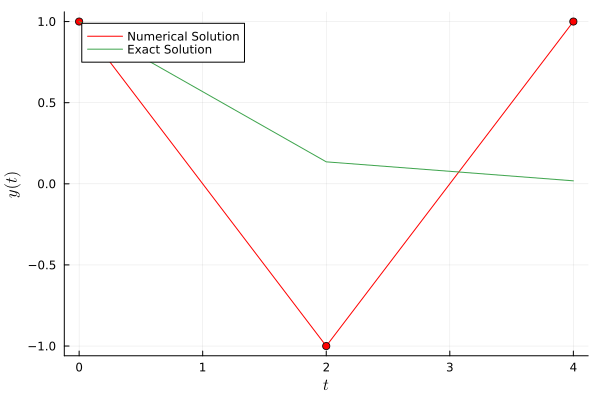

In [30]:
using Plots
gr()
plt = plot()
plot!(plt, t, real.(y), color = :red, label = "Numerical Solution")
scatter!(plt, t, real.(y), color = :red, label = "")
plot!(plt, t, real.(y0 * exp.(λ * t)), label = "Exact Solution")
plot!(plt, ylabel = "y", color = :blue, zlabel = "z")
plot!(ylabel = "\$y(t)\$", xlabel = "\$t\$")
plot!(plt, legend = :topleft)


**1a)** Try different values of `dt` and initial data. See what happens as `dt` increases or decreases. How does the system behave if $\lambda$ and $y_0$ are complex numbers?

*Hint: A complex number $c = a + bi$ is defined in Julia as `c = a + bim`. The functions `real(c)` and `imag(c)` return `a` and `b` respectively.*


**1b)** Use the values $N=201$, $N=401$ and $N=801$ to compute the $Q$ factor of the Euler method. Choosing these $N$ values will give us three different values of $\Delta t$, each half the value of the previous one.

 *Hint: Build a function that calculates the $Q$ factor given three solutions with three different resolutions. If the Q value you find is not working, verify that the $\Delta t$ values are of the form $\Delta t$, $\Delta t/2$ and $\Delta t / 4$. If you choose the wrong $N$ values this will not be the case.*

**1c)**
Using $\lambda = 1, y_0 = 1$, implement the second- and fourth-order Runge-Kutta methods by creating two functions called `RK2step` and `RK4step`, similar to `EulerStep`. Plot again for different values of $N$ and compute the $Q$ factor for these methods.
 

**2) Stability of the solution**

Consider the equation
$$
\frac{dy}{dt} = y - y^2
$$

This equation has two stationary points: $y(t) = 1$ and $y(t) = 0$. Evolve the solution numerically with `y0 = 0:0.1:2` (that is, with initial data $y_0 = 0, y_0 = 0.1, ..., y_0 = 2$). Use the time interval $[0, 10]$. Plot using different methods and values of N and try to understand the behavior of the solution.

*Optional:* To observe the behavior for negative $y_0$, try `y0 = (0:-0.1:-0.5)` over the time interval $[0,1]$.


**3) Systems of equations**

The second-order ordinary differential equation
$$
\dfrac{d^{2}u(t)}{dt^2} = -\alpha^{2} u(t), \quad \alpha > 0
$$

has the general solution $u = A\cos(\alpha t) + B\sin(\alpha t)$.

To solve it numerically, we can convert it into a system of first-order ordinary differential equations by defining $v = \dfrac{du}{dt}$.

$$
    \begin{array}{c}
    \dfrac{du}{dt} &= &  v \\
    \dfrac{dv}{dt} &= &-\alpha^{2} u
    \end{array}
$$

**a)** Consider $$\alpha = 1, \quad u(0) = 1,\quad  v(0) = 0.$$  
Plot and compare the performance of the different methods with the exact solution.

*Hint: define `y0 = [u0, v0]`*

**4)** **Conservation**

Consider the Lotka-Volterra predator-prey system. In this system of equations, $x$ represents a prey population, and $y$ represents a predator population.
$$
\begin{aligned}
 \frac{dx}{dt} &= \alpha x - \beta x y, \\
 \frac{dy}{dt} &= - \gamma y + \delta x y ,
\end{aligned}
$$

$\alpha$, $\beta$, $\gamma$ and $\delta$ are positive constants. $\alpha$ represents the growth rate of the prey population in the absence of predators, $\gamma$ represents the decay rate of the predator population in the absence of prey, and $\beta$ and $\delta$ prepresents the decay and growth rate of the prey and predator populations due to predation.

Consider a case where $x(0) = 1$, $y(0) = 1$ in the interval $t=[0,20]$, and parameters $\alpha=1.5, \beta=1, \gamma=3, \delta=1$. 


The function $V(x,y) = \delta x - \gamma \ln(x) + \beta y - \alpha \ln(y)$ is a conserved quantity, that is, it is constant throughout the evolution. You can verify this by seeing that 
$$\dfrac{dV}{dt} = 0.$$

***4.1)*** Solve the equation with Euler and Runge-Kutta 4 (and other methods if you want), and study how well conservation is numerically obeyed.

***4.2)*** Find the fixed point of the equation, for which $\dfrac{dx}{dt}=\dfrac{dy}{dt}=0$. Plot the phase diagram $x$ vs. $y$ for several values of the initial data at different distances from the fixed point.

**5)** **Numerical Stability**

***5.1)***
Let's return to the equation from the previous notebook

$$
\frac{dy}{dt} = \lambda y
$$

Solve the equation with $\lambda = -1$ in the time interval $[0,20]$, with $N = 100, 50, 30, 20, 10, 5$ (that is, for increasing $\Delta t$). Experiment with Euler and Runge-Kutta and plot. What do you observe?.

***5.2)*** Use the *stability_region* notebook to investigate the convergence region of various methods from the libraries. You don't need to do more than read the notebook, understand it, and run the examples. Ask all your questions in class, it's a concept that can be difficult to understand.

**6) Solve your own differential equation**

Use the `Differential Equations` package to solve your favourite ODE. You can draw inspiration from the examples section of "https://docs.sciml.ai/DiffEqDocs/stable/". Plot the $Q$ factor for two methods. Remember to pass the argument `adaptive=false` to the `solve()` function when doing this, otherwise it may adapt the `dt` value you are trying to use.

***Documentation:***
Optional arguments for the `solve` function: https://diffeq.sciml.ai/stable/basics/common_solver_opts/